In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
import cv2
import os

# Define paths to image folders
train_low_folder = "/home/dgreen/sem2/dl/finalProject/LOL-v2/LOL-v2/Real_captured/Train/Low"  # Path to folder containing low-resolution training images
train_high_folder = "/home/dgreen/sem2/dl/finalProject/LOL-v2/LOL-v2/Real_captured/Train/Normal"  # Path to folder containing high-resolution training images
eval_low_folder = "/home/dgreen/sem2/dl/finalProject/LOL-v2/LOL-v2/Real_captured/Test/Low"  # Path to folder containing low-resolution evaluation images
eval_high_folder = "/home/dgreen/sem2/dl/finalProject/LOL-v2/LOL-v2/Real_captured/Test/Normal"  # Path to folder containing high-resolution evaluation images


# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/dgreen/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_low_images_list = []
train_high_images_list = []
eval_low_images_list = []
eval_high_images_list = []

for filename in os.listdir(train_low_folder):
    if "png" in filename.strip().split(".")[-1]:
        train_low_images_list.append(filename)

for filename in os.listdir(train_high_folder):
    if "png" in filename.strip().split(".")[-1]:
        train_high_images_list.append(filename)

for filename in os.listdir(eval_low_folder):
    if "png" in filename.strip().split(".")[-1]:
        eval_low_images_list.append(filename)

for filename in os.listdir(eval_high_folder):
    if "png" in filename.strip().split(".")[-1]:
        eval_high_images_list.append(filename)

In [3]:
# Load low-resolution and high-resolution images using OpenCV
train_low_images = [cv2.imread(os.path.join(train_low_folder, filename)) for filename in train_low_images_list]
train_high_images = [cv2.imread(os.path.join(train_high_folder, filename)) for filename in train_high_images_list]
eval_low_images = [cv2.imread(os.path.join(eval_low_folder, filename)) for filename in eval_low_images_list]
eval_high_images = [cv2.imread(os.path.join(eval_high_folder, filename)) for filename in eval_high_images_list]

In [4]:
# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, low_res_images, high_res_images, transform=None):
        self.low_res_images = low_res_images
        self.high_res_images = high_res_images
        self.transform = transform

    def __len__(self):
        return len(self.low_res_images)

    def __getitem__(self, idx):
        low_res_image = self.low_res_images[idx]
        high_res_image = self.high_res_images[idx]

        if self.transform:
            low_res_image = self.transform(low_res_image)
            high_res_image = self.transform(high_res_image)

        return low_res_image.to(device), high_res_image.to(device)

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Create custom datasets
train_dataset = CustomDataset(train_low_images, train_high_images, transform=transform)
eval_dataset = CustomDataset(eval_low_images, eval_high_images, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=1)

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os

# -----------------------------------
# 1. Generator and Residual Block
# -----------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, n_residual_blocks=9):
        super(Generator, self).__init__()
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_channels, 64, 7),
                 nn.InstanceNorm2d(64),
                 nn.ReLU(inplace=True)]
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model.extend([nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                          nn.InstanceNorm2d(out_features),
                          nn.ReLU(inplace=True)])
            in_features = out_features
            out_features *= 2
        for _ in range(n_residual_blocks):
            model.append(ResidualBlock(in_features))
        out_features = in_features // 2
        for _ in range(2):
            model.extend([nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                          nn.InstanceNorm2d(out_features),
                          nn.ReLU(inplace=True)])
            in_features = out_features
            out_features = in_features // 2
        model.extend([nn.ReflectionPad2d(3),
                      nn.Conv2d(64, output_channels, 7),
                      nn.Tanh()])
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# -----------------------------------
# 2. Discriminator
# -----------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

# -----------------------------------
# 3. Initialize Models
# -----------------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G_AB = Generator(3, 3).to(device)
G_BA = Generator(3, 3).to(device)
D_A = Discriminator(3).to(device)
D_B = Discriminator(3).to(device)
print('Models moved to GPU.')

# -----------------------------------
# 4. Losses and Optimizers
# -----------------------------------
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

optimizer_G = optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))


Models moved to GPU.


In [6]:
def train_cycle_gan(loader_A, loader_B, epochs=100, save_interval=10):
    G_losses, D_losses = [], []

    for epoch in range(epochs):
        iteration=0
        for real_A, real_B in zip(loader_A, loader_B):
            real_A, real_B = real_A[0].to(device), real_B[0].to(device)

            # print(real_A[0][0])
            # real_A = real_A.to(device)
            # real_B = real_B.to(device)

            valid = torch.ones(real_A.size(0), 1, device=device, requires_grad=False)
            fake = torch.zeros(real_A.size(0), 1, device=device, requires_grad=False)

            ######################
            #  Train Generators  #
            ######################
            optimizer_G.zero_grad()

            # Identity loss
            loss_identity_A = criterion_identity(G_BA(real_A), real_A)
            loss_identity_B = criterion_identity(G_AB(real_B), real_B)

            # GAN loss
            fake_B = G_AB(real_A)
            loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
            fake_A = G_BA(real_B)
            loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

            # Cycle loss
            recovered_A = G_BA(fake_B)
            recovered_B = G_AB(fake_A)
            loss_cycle_ABA = criterion_cycle(recovered_A, real_A)
            loss_cycle_BAB = criterion_cycle(recovered_B, real_B)

            # Total loss for generators
            total_loss_G = (loss_identity_A + loss_identity_B) * 5.0 + (loss_GAN_AB + loss_GAN_BA) + (loss_cycle_ABA + loss_cycle_BAB) * 10.0
            total_loss_G.backward()
            optimizer_G.step()

            #############################
            #  Train Discriminator D_A  #
            #############################
            optimizer_D_A.zero_grad()

            # Real loss
            loss_D_real_A = criterion_GAN(D_A(real_A), valid)

            # Fake loss (on detached fake_A to avoid training G on these labels)
            fake_A = G_BA(real_B).detach()
            loss_D_fake_A = criterion_GAN(D_A(fake_A), fake)

            # Total loss for discriminator A
            total_loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
            total_loss_D_A.backward()
            optimizer_D_A.step()

            #############################
            #  Train Discriminator D_B  #
            #############################
            optimizer_D_B.zero_grad()

            # Real loss
            loss_D_real_B = criterion_GAN(D_B(real_B), valid)

            # Fake loss (on detached fake_B to avoid training G on these labels)
            fake_B = G_AB(real_A).detach()
            loss_D_fake_B = criterion_GAN(D_B(fake_B), fake)

            # Total loss for discriminator B
            total_loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
            total_loss_D_B.backward()
            optimizer_D_B.step()

            # Collect losses for logging
            G_losses.append(total_loss_G.item())
            D_losses.append((total_loss_D_A.item() + total_loss_D_B.item()) / 2)
            print(f"{epoch + 1}:{iteration} , G Loss: {total_loss_G.item():.4f}, D Loss: {(total_loss_D_A.item() + total_loss_D_B.item()) / 2:.4f}")
            iteration+=1

        # Logging and saving checkpoints
        print(f"Epoch [{epoch + 1}/{epochs}], G Loss: {total_loss_G.item():.4f}, D Loss: {(total_loss_D_A.item() + total_loss_D_B.item()) / 2:.4f}")

        if (epoch + 1) % save_interval == 0:
            torch.save(G_AB.state_dict(), f'G_AB_epoch_{epoch + 1}.pth')
            torch.save(G_BA.state_dict(), f'G_BA_epoch_{epoch + 1}.pth')
            torch.save(D_A.state_dict(), f'D_A_epoch_{epoch + 1}.pth')
            torch.save(D_B.state_dict(), f'D_B_epoch_{epoch + 1}.pth')

    return G_losses, D_losses


In [9]:
train_cycle_gan(train_loader,eval_loader)

/home/dgreen/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 48, 73])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1:0 , G Loss: 26.1226, D Loss: 1.0331
1:1 , G Loss: 17.7487, D Loss: 1.0373
1:2 , G Loss: 13.0662, D Loss: 2.7930
1:3 , G Loss: 12.3144, D Loss: 0.4842
1:4 , G Loss: 7.2053, D Loss: 0.9535
1:5 , G Loss: 5.1097, D Loss: 0.6907
1:6 , G Loss: 4.5094, D Loss: 0.4890
1:7 , G Loss: 4.6508, D Loss: 0.4823
1:8 , G Loss: 4.6037, D Loss: 0.4163
1:9 , G Loss: 5.2473, D Loss: 0.5029
1:10 , G Loss: 3.0757, D Loss: 0.3186
1:11 , G Loss: 2.9685, D Loss: 0.3875
1:12 , G Loss: 3.5593, D Loss: 0.3740
1:13 , G Loss: 3.0099, D Loss: 0.3328
1:14 , G Loss: 4.6395, D Loss: 0.3136
1:15 , G Loss: 3.1179, D Loss: 0.3074
1:16 , G Loss: 2.3235, D Loss: 0.2868
1:17 , G Loss: 3.0640, D Loss: 0.3121
1:18 , G Loss: 4.7678, D Loss: 0.2820
1:19 , G Loss: 1.9556, D Loss: 0.2598
1:20 , G Loss: 2.4971, D Loss: 0.2929
1:21 , G Loss: 1.8866, D Loss: 0.2753
1:22 , G Loss: 3.4328, D Loss: 0.3055
1:23 , G Loss: 3.5733, D Loss: 0.2900
1:24 , G Loss: 3.4146, D Loss: 0.2724
1:25 , G Loss: 3.5999, D Loss: 0.2497
1:26 , G Loss: 2.5

([26.122631072998047,
  17.74871826171875,
  13.06618881225586,
  12.314417839050293,
  7.205292224884033,
  5.109651565551758,
  4.509369373321533,
  4.650837421417236,
  4.603708744049072,
  5.247262477874756,
  3.07568097114563,
  2.968486785888672,
  3.5592970848083496,
  3.009866714477539,
  4.639477252960205,
  3.1178789138793945,
  2.3235344886779785,
  3.0640482902526855,
  4.7677717208862305,
  1.9556479454040527,
  2.4971351623535156,
  1.8865840435028076,
  3.4327902793884277,
  3.57332181930542,
  3.414555549621582,
  3.5999135971069336,
  2.5448837280273438,
  2.720818519592285,
  2.31131649017334,
  2.5640053749084473,
  2.0170669555664062,
  2.386079788208008,
  2.888356924057007,
  3.536163330078125,
  2.8730504512786865,
  2.4937126636505127,
  2.778393030166626,
  1.8863201141357422,
  3.299640655517578,
  2.726649284362793,
  3.751598596572876,
  4.5011396408081055,
  2.029356002807617,
  3.908069610595703,
  2.6622090339660645,
  2.1764750480651855,
  2.905945301055

In [7]:
def load_last_model(model_type, epoch):
    model_path = f'{model_type}_epoch_{epoch}.pth'
    if os.path.exists(model_path):
        model = Generator(3, 3) if 'G' in model_type else Discriminator(3)
        model.load_state_dict(torch.load(model_path))
        return model
    else:
        print(f"No model found for {model_type} at epoch {epoch}.")
        return None

# Load the last models
last_epoch = 100  # Set this to the last epoch you trained for
G_AB = load_last_model('G_AB', last_epoch)
G_BA = load_last_model('G_BA', last_epoch)
# D_A = load_last_model('D_A', last_epoch)
# D_B = load_last_model('D_B', last_epoch)

# Ensure models are moved to the appropriate device
G_AB.to(device)
G_BA.to(device)
# D_A.to(device)
# D_B.to(device)

No model found for D_A at epoch 100.
No model found for D_B at epoch 100.


AttributeError: 'NoneType' object has no attribute 'to'

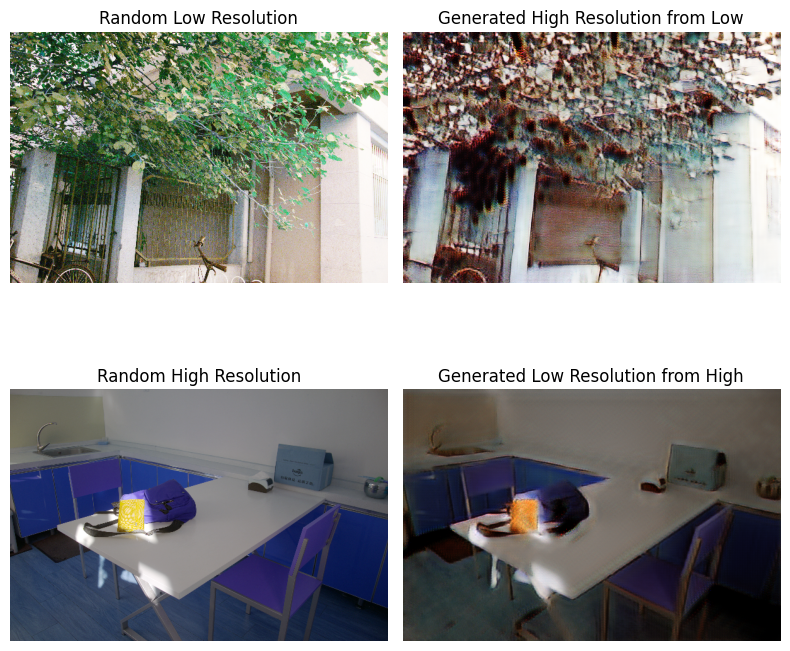

In [10]:
import matplotlib.pyplot as plt
from skimage import exposure
# Test the model on random images
G_AB.eval()
G_BA.eval()

random_idx = np.random.randint(len(eval_dataset))
random_low_res, random_high_res = eval_dataset[20]
random_low_res = random_low_res.unsqueeze(0).to(device)  # Add batch dimension and move to device
random_high_res = random_high_res.unsqueeze(0).to(device)  # Add batch dimension and move to device
normalized_data_low = (random_low_res - random_low_res.min()) / (random_low_res.max() - random_low_res.min())
normalized_data_high = (random_high_res - random_high_res.min()) / (random_high_res.max() - random_high_res.min())
with torch.no_grad():
    # Forward pass through the generators
    generated_high_res_from_low = G_AB(random_low_res)
    generated_low_res_from_high = G_BA(random_high_res)

def adjust_color_balance(image):
    # Example: Apply a simple color balance adjustment by increasing the red channel
    image[:,:,:] *= 1.25  # Increase red channel

    # Clip values to ensure they are in the valid range [0, 1]
    image = np.clip(image, 0, 1)
    
    return image

# Move generated images to CPU and convert to NumPy arrays
generated_high_res_from_low_np = generated_high_res_from_low.squeeze(0).permute(1, 2, 0).cpu().numpy()
generated_high_res_from_low_np = (generated_high_res_from_low_np - generated_high_res_from_low_np.min()) / (generated_high_res_from_low_np.max() - generated_high_res_from_low_np.min())
generated_high_res_from_low_np = adjust_color_balance(generated_high_res_from_low_np)
generated_high_res_from_low_np = exposure.equalize_hist(generated_high_res_from_low_np)

generated_low_res_from_high_np = generated_low_res_from_high.squeeze(0).permute(1, 2, 0).cpu().numpy()
generated_low_res_from_high_np = (generated_low_res_from_high_np - generated_low_res_from_high_np.min()) / (generated_low_res_from_high_np.max() - generated_low_res_from_high_np.min())
generated_low_res_from_high_np = adjust_color_balance(generated_low_res_from_high_np)

random_low_res_np = normalized_data_low.squeeze(0).permute(1, 2, 0).cpu().numpy()
random_low_res_np = exposure.equalize_hist(random_low_res_np)

random_high_res_np = normalized_data_high.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Plot the images
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

axes[0, 0].imshow(random_low_res_np)
axes[0, 0].set_title('Random Low Resolution')
axes[0, 0].axis('off')

axes[0, 1].imshow(generated_high_res_from_low_np)
axes[0, 1].set_title('Generated High Resolution from Low')
axes[0, 1].axis('off')

axes[1, 0].imshow(random_high_res_np)
axes[1, 0].set_title('Random High Resolution')
axes[1, 0].axis('off')

axes[1, 1].imshow(generated_low_res_from_high_np)
axes[1, 1].set_title('Generated Low Resolution from High')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()
